# Binary Voting Predictor - Combined Categorical and Numerical Data

- Decision Tree based on voting logic
- Each variable is transformed into a "vote", which is either -1 or 1 depending on the variable value

In [2]:
%load_ext autoreload
%autoreload 2

In [47]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB

In [4]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [5]:
data = loan_approval_lib.load_original_data()

In [6]:
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


# Data Cleaning

In [7]:
columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_default_on_file'
]

for column in columns:
    row_count_1 = len(data)

    if column == 'person_age':
        data = data[data['person_age'] <= 100]

    if column == 'person_emp_length':
        data = data[data['person_emp_length'] <= 100]

    data = data[data[column].isna() == False]
    
    row_count_2 = len(data)
    row_count_diff = row_count_1 - row_count_2
    print(f'column {column}, number of removed rows: {row_count_diff}')

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


# Loan Grade

In [8]:
loan_grades = list(sorted(data['loan_grade'].unique()))

data['loan_grade_vote'] = 0

for loan_grade in loan_grades:
    data.loc[data['loan_grade'] == loan_grade, 'loan_grade_vote'] = -1 if loan_grade <= 'C' else 1

data['loan_grade_predict'] = data['loan_grade_vote'].map(lambda x: 0 if x == -1 else 1)

In [9]:
(data['loan_status'] == data['loan_grade_predict']).sum() / len(data)

np.float64(0.8180008382229673)

In [51]:
accuracy_root = 0.818

entropy_root = accuracy_root * math.log2(accuracy_root) #+ (1-accuracy_root) * math.log2(1-accuracy_root)
entropy_root

# wrong value?

-0.2370786919072367

In [71]:
P_0 = (data['loan_status'] == 0).sum() / len(data)
P_1 = 1 - P_0

P_0, P_1

(np.float64(0.7833892148644873), np.float64(0.21661078513551268))

In [75]:
P_0 * math.log2(P_0) + P_1 * math.log2(P_1)

np.float64(-0.7539304302315522)

In [73]:
n = len(data)

double_sum = 0.0
for index, row in data.iterrows():
    for k in [0, 1]:
        y_i = row['loan_status']
        I = 1 if y_i == k else 0
        x_i = row['loan_grade']
        T_k = row['loan_grade_predict'] # 0 if 'loan_grade' <= 'C' else 1
        #print(f'T_k={T_k}')
        #sum_value = I * math.log2(T_k)
        P_k = P_0 if k == 0 else P_1
        sum_value = I * math.log2(P_k)
        double_sum += sum_value

LL = -(1/n) * double_sum

LL

0.7539304302312314

In [74]:
clf.tree_.impurity[0]

np.float64(0.7539304302315523)

In [52]:
22430

22430

In [53]:
6202

6202

In [55]:
22430 / (22430+6202)

0.7833892148644873

In [65]:
(data['loan_status'] == 0).sum()

np.int64(22430)

In [66]:
(data['loan_status'] == 1).sum()

np.int64(6202)

# Person Home Ownership

In [10]:
data.loc[data['person_home_ownership'] == 'OWN', 'person_home_ownership_vote'] = -1
data.loc[data['person_home_ownership'] == 'MORTGAGE', 'person_home_ownership_vote'] = -1
data.loc[data['person_home_ownership'] == 'RENT', 'person_home_ownership_vote'] = 1
data.loc[data['person_home_ownership'] == 'OTHER', 'person_home_ownership_vote'] = 1

data['person_home_ownership_predict'] = data['person_home_ownership_vote'].map(lambda x: 0 if x == -1 else 1)

In [11]:
(data['loan_status'] == data['person_home_ownership_predict']).sum() / len(data)

np.float64(0.5912964515227718)

# Loan Intent

In [12]:
data.loc[data['loan_intent'] == 'DEBTCONSOLIDATION', 'loan_intent_vote'] = 1
data.loc[data['loan_intent'] == 'EDUCATION', 'loan_intent_vote'] = -1
data.loc[data['loan_intent'] == 'HOMEIMPROVEMENT', 'loan_intent_vote'] = 1
data.loc[data['loan_intent'] == 'MEDICAL', 'loan_intent_vote'] = 1
data.loc[data['loan_intent'] == 'PERSONAL', 'loan_intent_vote'] = -1
data.loc[data['loan_intent'] == 'VENTURE', 'loan_intent_vote'] = -1

data['loan_intent_predict'] = data['loan_intent_vote'].map(lambda x: 0 if x == -1 else 1)

In [13]:
(data['loan_status'] == data['loan_intent_predict']).sum() / len(data)

np.float64(0.5745319921765857)

# Default on File

In [14]:
data.loc[data['cb_person_default_on_file'] == 'Y', 'cb_person_default_on_file_vote'] = 1
data.loc[data['cb_person_default_on_file'] == 'N', 'cb_person_default_on_file_vote'] = -1

data['cb_person_default_on_file_predict'] = data['cb_person_default_on_file_vote'].map(lambda x: 0 if x == -1 else 1)

In [15]:
(data['loan_status'] == data['cb_person_default_on_file_predict']).sum() / len(data)

np.float64(0.739731768650461)

# All Numerical Columns

In [16]:
columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
]

median_by_column = {}
P_by_column = {}
sign_by_column = {}

for column in columns:
    data_copy = data[[column, 'loan_status']].copy()
    median_value = numpy.median(data_copy[column])

    median_by_column[column] = median_value

    data_copy[f'{column}_sub_median'] = data_copy[column] - median_value
    data_copy[f'{column}_direction'] = (data_copy[f'{column}_sub_median'] > 0).astype(int)

    P_value = (data_copy[f'{column}_direction'] == data_copy['loan_status']).sum() / len(data_copy)
    P_by_column[column] = P_value

    if P_value < 0.5:
        sign_by_column[column] = -1
    else:
        sign_by_column[column] = 1

In [17]:
median_by_column

{'person_age': np.float64(26.0),
 'person_income': np.float64(55900.0),
 'person_emp_length': np.float64(4.0),
 'loan_amnt': np.float64(8000.0),
 'loan_int_rate': np.float64(10.99),
 'loan_percent_income': np.float64(0.15),
 'cb_person_cred_hist_length': np.float64(4.0)}

In [18]:
for column in columns:
    data[f'{column}_vote'] = sign_by_column[column] * (2 * (data[column] > median_by_column[column]).astype(int) - 1)
    data[f'{column}_predict'] = data[f'{column}_vote'].map(lambda x: 0 if x == -1 else 1)

In [19]:
for column in columns:
    P_tmp = (data['loan_status'] == data[f'{column}_predict']).sum() / len(data)
    print(f'{column}: {P_tmp}')

person_age: 0.5166946074322436
person_income: 0.5849399273540095
person_emp_length: 0.5104079351774239
loan_amnt: 0.5398505169041632
loan_int_rate: 0.6015996088292819
loan_percent_income: 0.6175956971221012
cb_person_cred_hist_length: 0.5166946074322436


In [20]:
# run this to combine the numerical column votes
# might not be the approach we want to take, eg maybe use tree based approach

all_columns = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length',
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file',
]

data['loan_status_vote'] = 0

for column in all_columns:
    data['loan_status_vote'] += data[f'{column}_vote']

In [21]:
data['loan_status_predict'] = (data['loan_status_vote'] > 0).astype(int)

In [22]:
accuracy = (data['loan_status_predict'] == data['loan_status']).sum() / len(data)
accuracy

np.float64(0.7166107851355127)

In [23]:
for column in data.columns:
    print(column)

person_age
person_income
person_home_ownership
person_emp_length
loan_intent
loan_grade
loan_amnt
loan_int_rate
loan_percent_income
cb_person_default_on_file
cb_person_cred_hist_length
loan_status
loan_grade_vote
loan_grade_predict
person_home_ownership_vote
person_home_ownership_predict
loan_intent_vote
loan_intent_predict
cb_person_default_on_file_vote
cb_person_default_on_file_predict
person_age_vote
person_age_predict
person_income_vote
person_income_predict
person_emp_length_vote
person_emp_length_predict
loan_amnt_vote
loan_amnt_predict
loan_int_rate_vote
loan_int_rate_predict
loan_percent_income_vote
loan_percent_income_predict
cb_person_cred_hist_length_vote
cb_person_cred_hist_length_predict
loan_status_vote
loan_status_predict


In [24]:
decision_tree_columns = [
    column for column in data.columns if column.endswith('_vote') and column != 'loan_status_vote'
]

for column in decision_tree_columns:
    print(column)

loan_grade_vote
person_home_ownership_vote
loan_intent_vote
cb_person_default_on_file_vote
person_age_vote
person_income_vote
person_emp_length_vote
loan_amnt_vote
loan_int_rate_vote
loan_percent_income_vote
cb_person_cred_hist_length_vote


In [25]:
X = data[decision_tree_columns].copy()
Y = data['loan_status'].copy()

In [26]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)

In [27]:
Z = clf.predict(X)

In [28]:
data['loan_status_tree_predict'] = Z

In [29]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.8518091645711092)

In [30]:
clf.tree_.feature[0]

np.int64(0)

In [31]:
X.columns[clf.tree_.feature[0]]

'loan_grade_vote'

In [32]:
clf.tree_.threshold[0]

np.float64(0.0)

In [33]:
clf.tree_.impurity[0]

np.float64(0.7539304302315523)

In [34]:
clf.tree_.n_node_samples[0]

np.int64(28632)

In [35]:
clf.tree_.value[0]

array([[0.78338921, 0.21661079]])

In [36]:
clf.tree_.children_left[0]

np.int64(1)

In [37]:
clf.tree_.children_left[1]

np.int64(2)

In [38]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_grade_vote                    0.397183
person_home_ownership_vote         0.170978
loan_percent_income_vote           0.163271
loan_intent_vote                   0.084079
person_income_vote                 0.059417
person_emp_length_vote             0.040515
loan_amnt_vote                     0.037440
loan_int_rate_vote                 0.020147
cb_person_default_on_file_vote     0.013631
cb_person_cred_hist_length_vote    0.007468
person_age_vote                    0.005872
dtype: float64


In [39]:
clf.max_features_

11

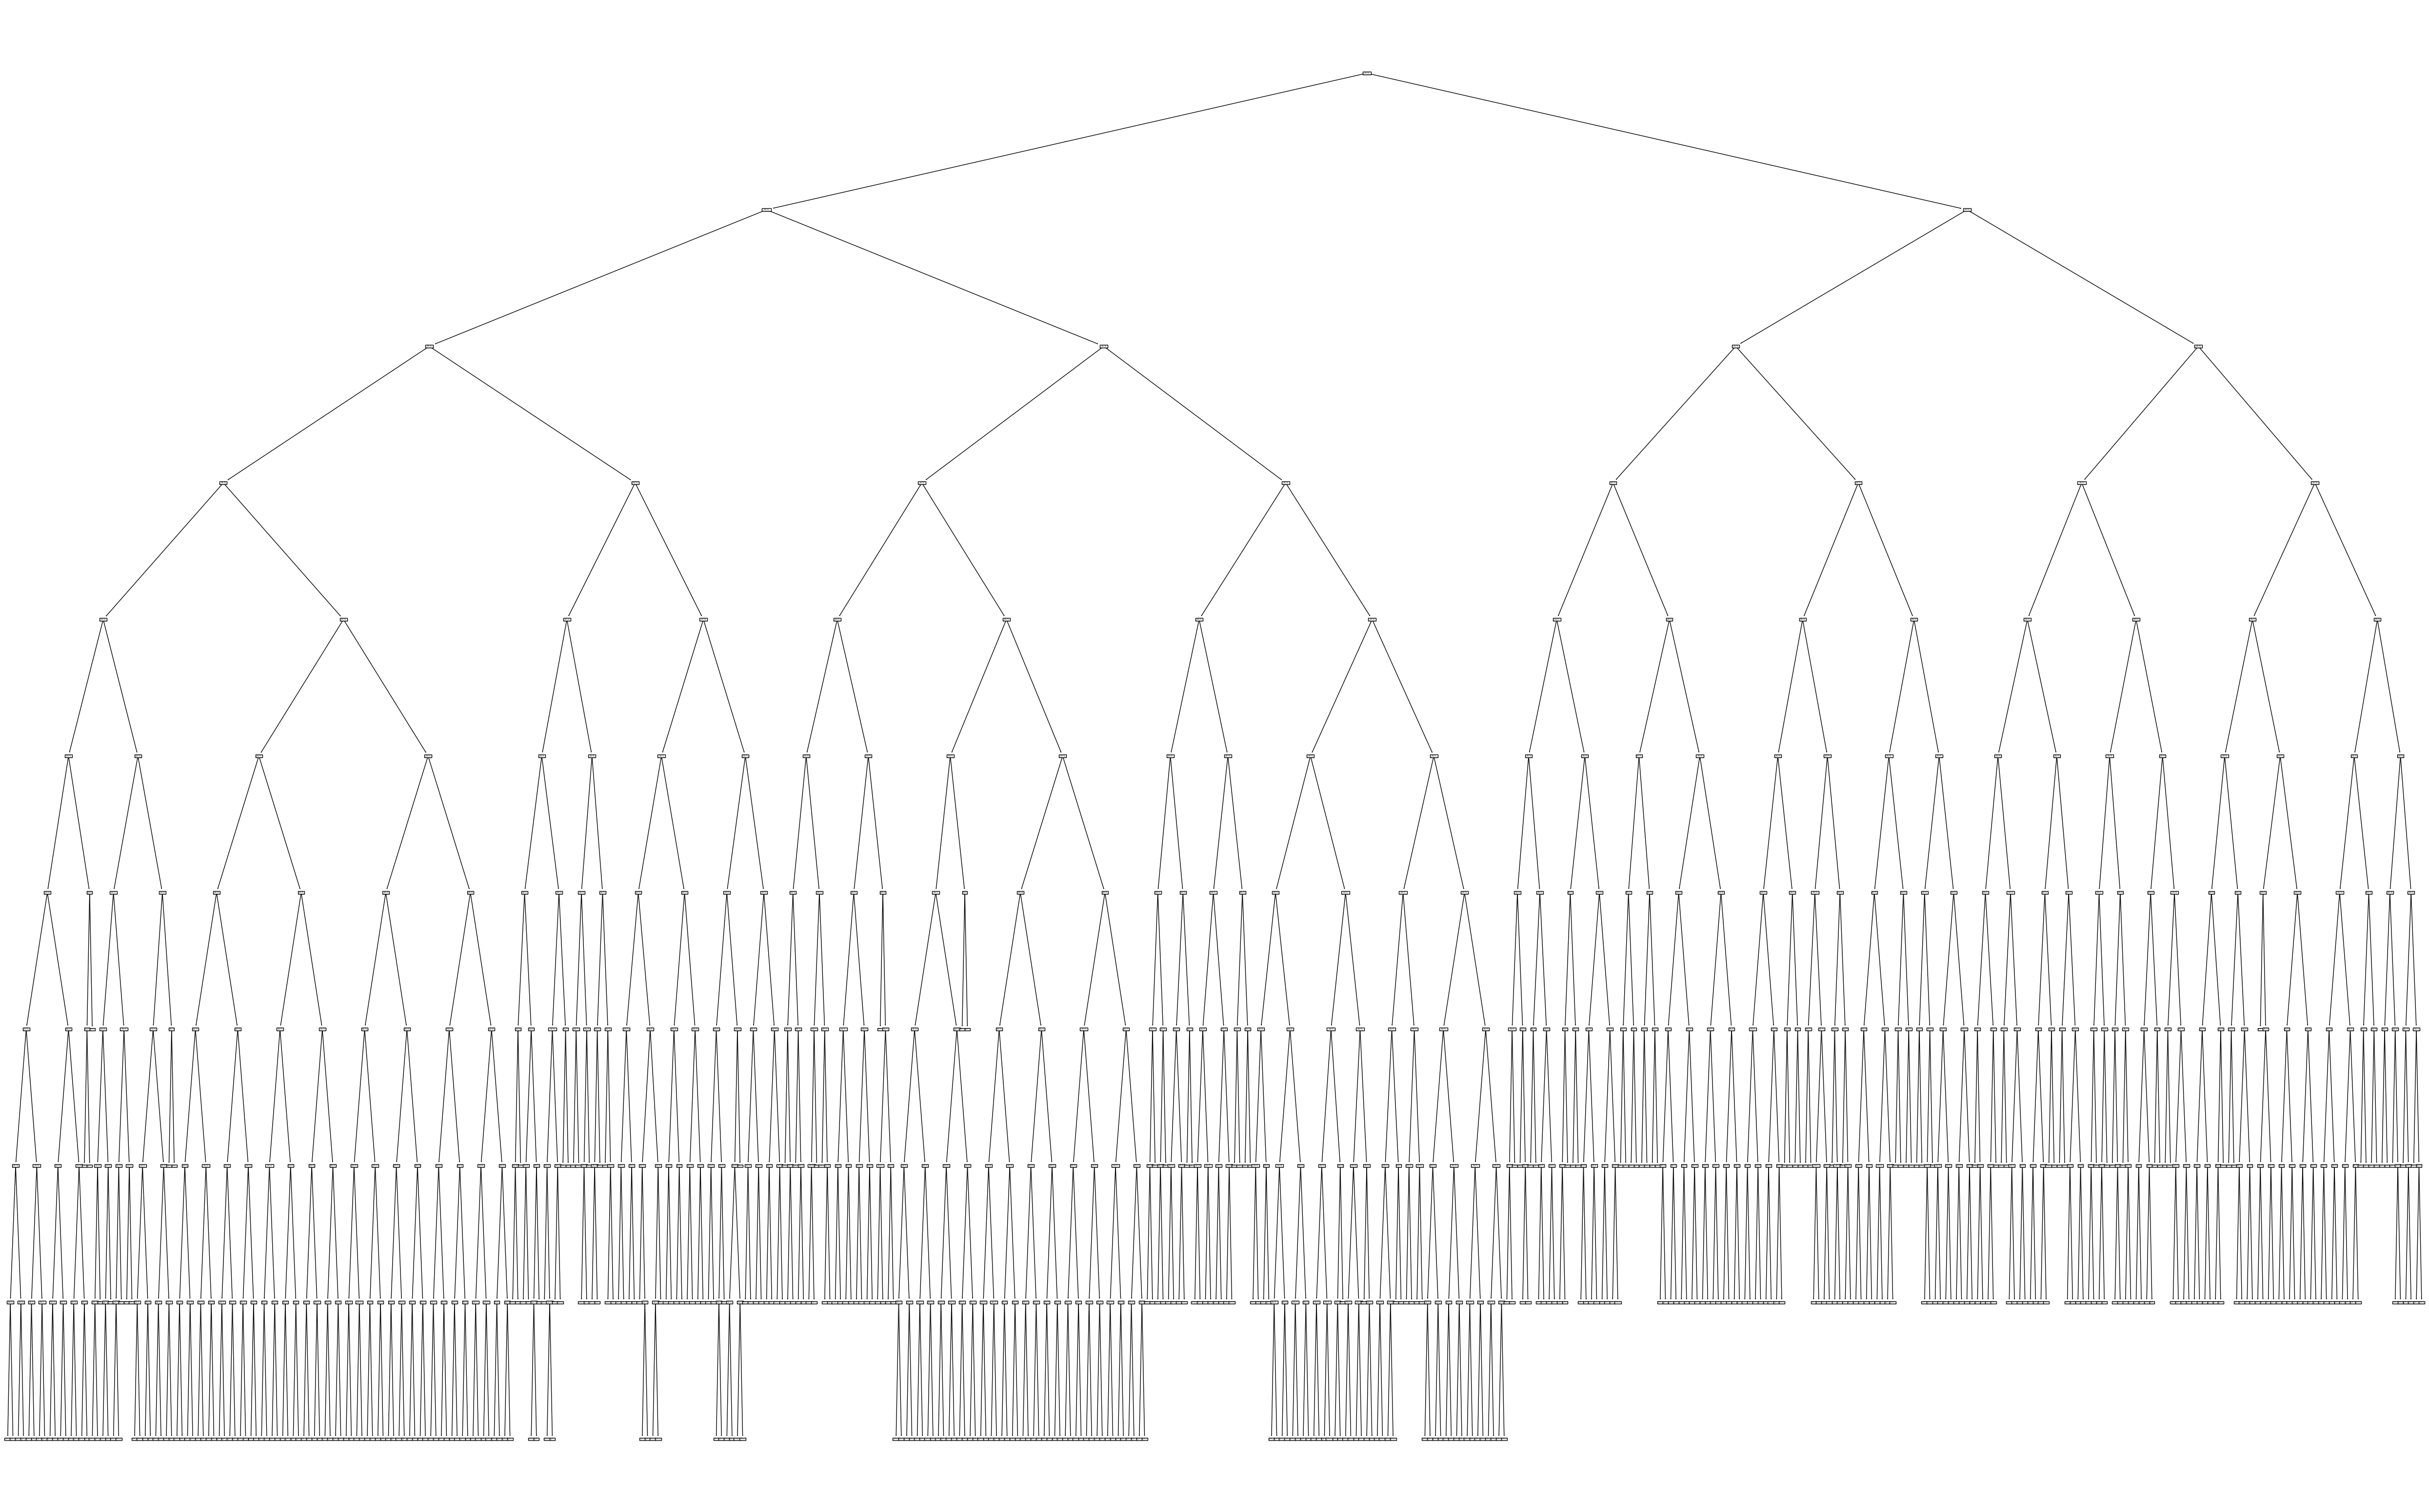

In [81]:
width = 64
height = 40
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf) #, max_depth=tree_plot_max_depth)

plt.savefig('tree.png')
plt.show()

# Max Depth 1 Decision Tree Classifier

The accuracy of the depth 1 decision tree is just the accuracy of selecting by `loan_grade`

In [108]:
data['loan_status_tree_predict'] = data['loan_grade'].map(lambda x: 0 if x <= 'C' else 1)
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.8180008382229673)

Check the value of the depth 1 decision tree classifier using the Decision Tree classification algorithm

In [109]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf = clf.fit(X, Y)

In [110]:
Z = clf.predict(X)

In [111]:
data['loan_status_tree_predict'] = Z

In [112]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.8180008382229673)

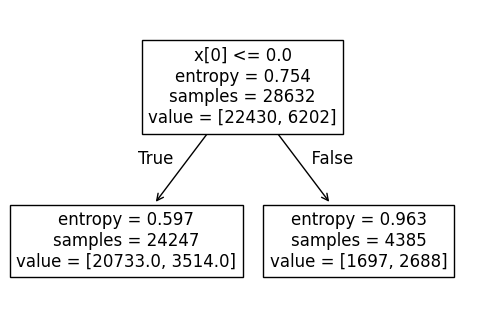

In [114]:
width = 6
height = 4
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf) #, max_depth=tree_plot_max_depth)

plt.savefig('tree-max-depth-1.pdf')
plt.savefig('tree-max-depth-1.png')
plt.show()

In [115]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_grade_vote                    1.0
person_home_ownership_vote         0.0
loan_intent_vote                   0.0
cb_person_default_on_file_vote     0.0
person_age_vote                    0.0
person_income_vote                 0.0
person_emp_length_vote             0.0
loan_amnt_vote                     0.0
loan_int_rate_vote                 0.0
loan_percent_income_vote           0.0
cb_person_cred_hist_length_vote    0.0
dtype: float64


# Max Depth 2 Decision Tree Classifier

In [89]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf = clf.fit(X, Y)

In [90]:
Z = clf.predict(X)

In [91]:
data['loan_status_tree_predict'] = Z

In [92]:
(data['loan_status'] == data['loan_status_tree_predict']).sum() / len(data)

np.float64(0.829491478066499)

In [93]:
feature_importances = pandas.Series(clf.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

loan_grade_vote                    0.636868
loan_percent_income_vote           0.249115
loan_intent_vote                   0.114018
person_home_ownership_vote         0.000000
cb_person_default_on_file_vote     0.000000
person_income_vote                 0.000000
person_age_vote                    0.000000
person_emp_length_vote             0.000000
loan_amnt_vote                     0.000000
loan_int_rate_vote                 0.000000
cb_person_cred_hist_length_vote    0.000000
dtype: float64


In [94]:
for index, column in enumerate(data[decision_tree_columns].columns):
    print(f'feature i={index} is {column}')

feature i=0 is loan_grade_vote
feature i=1 is person_home_ownership_vote
feature i=2 is loan_intent_vote
feature i=3 is cb_person_default_on_file_vote
feature i=4 is person_age_vote
feature i=5 is person_income_vote
feature i=6 is person_emp_length_vote
feature i=7 is loan_amnt_vote
feature i=8 is loan_int_rate_vote
feature i=9 is loan_percent_income_vote
feature i=10 is cb_person_cred_hist_length_vote


In [95]:
clf.tree_.value

array([[[0.78338921, 0.21661079]],

       [[0.85507485, 0.14492515]],

       [[0.93493868, 0.06506132]],

       [[0.75687356, 0.24312644]],

       [[0.38700114, 0.61299886]],

       [[0.57199125, 0.42800875]],

       [[0.18571429, 0.81428571]]])

In [96]:
clf.tree_.threshold[0]

np.float64(0.0)

In [97]:
clf.tree_.feature[0]

np.int64(0)

In [98]:
clf.tree_.impurity[0]

np.float64(0.7539304302315523)

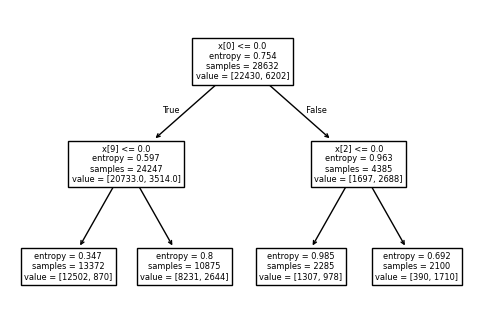

In [100]:
width = 6
height = 4
plt.figure(figsize=(width, height))

#tree_plot_max_depth = 6
tree.plot_tree(clf) #, max_depth=tree_plot_max_depth)

plt.savefig('tree-max-depth-2.pdf')
plt.savefig('tree-max-depth-2.png')
plt.show()

# Random Forest Classifier

In [88]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf = clf.fit(X, Y)

In [89]:
Z = clf.predict(X)

In [90]:
data['loan_status_random_forest_predict'] = Z

In [91]:
(data['loan_status'] == data['loan_status_random_forest_predict']).sum() / len(data)

np.float64(0.8517043867001955)